# Workshop figures

In [ ]:
%load_ext autoreload
%autoreload 2

import collections
import math
import numpy as np
from pathlib import Path
import re
import scipy.stats
import tqdm
import torch
from torch import tensor, Tensor
from typing import Iterable, Any

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
import seaborn as sns

import data_utils as D
import plot_utils
import weight_formats.analysis as A
import weight_formats.experiments as E
import weight_formats.quantisation as Q

plot_utils.OVERLEAF = Path("../overleaf_workshop").resolve()
plot_utils.configure()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def scaled_kl_ratio_label(num: str, denom: str) -> str:
    return f"$\\bar{{\\rho}}^{{\\,({num})}} / \\bar{{\\rho}}^{{\\,({denom})}}$"
def scaled_kl_ratio_label_nomean(num: str, denom: str) -> str:
    return f"$\\rho^{{\\,({num})}} / \\rho^{{\\,({denom})}}$"
def distribution_name(distribution: A.Distribution) -> str:
    if isinstance(distribution, A.StudentT):
        return f"t[$\\nu={distribution.df:.0f}$]"
    return type(distribution).__name__

Recommend (Ubuntu):
  sudo apt-get install cm-super dvipng fonts-cmu texlive-latex-extra


### `workshop_tradeoff_overview_llama8b`

In [2]:
BASELINES = E.runs("20250506-results-baseline")
WEIGHT_STATS = {r.config.model: r.summary.weight_stats for r in E.runs("20250423-weight-stats")}

RUNS_MAIN = E.runs("20250506-results-main", progress=True)
RUNS_FISHER = E.runs("20250506-results-fisher", progress=True)

RUNS = RUNS_MAIN + RUNS_FISHER

query: 4680it [00:27, 167.22it/s]
query: 1806it [00:11, 162.56it/s]


In [12]:
SELECTED_FORMATS = [
    (dict(element_name="int+Zoptimal", scaling="rms", block="tensor", sparse_ratio=0),
        dict(label="Tensor RMS + Compression", color=plot_utils.PALETTE[0])),
    (dict(element_name="t", scaling="rms", block="tensor", sparse_ratio=2**-10),
        dict(label="Tensor RMS + Sparsity", color=plot_utils.PALETTE[1])),
    (dict(element_name="t", scaling="absmax", block=128, sparse_ratio=0),
        dict(label=r"Block Absmax", color=plot_utils.PALETTE[2])),
]
BAD_FORMATS = [
    (dict(element_name="t", scaling="absmax", block="channel", sparse_ratio=0),
        dict(label="Channel Absmax", color=plot_utils.PALETTE[3])),
    (dict(element_name="t", scaling="absmax", block="tensor", sparse_ratio=0),
        dict(label="Tensor Absmax", color=plot_utils.PALETTE[4])),
    (dict(element_name="t", scaling="rms", block="tensor", sparse_ratio=0),
        dict(label="Tensor RMS", color=plot_utils.PALETTE[5])),
]
SELECTED_LABEL_ORDER = {d["label"]: n for n, (_, d) in enumerate(SELECTED_FORMATS)}


def recalculate_bits_per_param(model: str, param_log: dict[str, Any]) -> float:
    # For Gemma, where the estimate in the logs includes the vision part
    # Note that this is approximate - it excludes layernorm parameters which aren't in weight_stats or param_log
    assert set(WEIGHT_STATS[model]) - {"multi_modal_projector.mm_input_projection_weight"} == set(param_log)
    return sum(param_log[k]["bits"] for k in param_log) / sum(math.prod(WEIGHT_STATS[model][k]["shape"]) for k in param_log)


def get_element_format_name(fmt: E.AttrDict) -> str:
    name = fmt.element_family
    if name == "fp" and "exponent_bits" in fmt.args:
        name = f"{name}-E{fmt.args.exponent_bits:.0f}"
    if name == "t" and "df" in fmt.args:
        name = f"{name}[{fmt.args.df:.0f}]"
    if fmt.compressor is not None:
        if isinstance(fmt.compressor, (list, tuple)):
            compressor = f"+Z{fmt.compressor[0]}|Z{fmt.compressor[1]}"
        else:
            compressor = f"+Z{fmt.compressor}"
        name = f"{name}{compressor}"
    return name


def mean_and_stderr(name: str, data: list[float]) -> dict[str, float]:
    data = tensor(data)
    return {name: data.mean().item(),
            f"{name}_stderr": data.std().item() / len(data)**.5}


def _scaled_fmt(fmt: dict[str, Any]) -> dict[str, Any]:
    return dict(
        element_bits=fmt.element_bits,
        element_family=fmt.element_family,
        element_name=get_element_format_name(fmt),
        element_mode=fmt.args.get("mode", "default"),
        scaling=fmt.scaling,
        scaling_match=fmt.scaling_match,
        scale_mantissa_bits=7 if fmt.scale_format.get("dtype") == "bfloat16" else fmt.scale_format.mantissa_bits,
        block={(None, None): "tensor", (1, None): "channel"}.get(tuple(fmt.block_shape), fmt.block_shape[1]),
        sparse_ratio=fmt.sparse_ratio,
        compression=fmt.compressor == "optimal",
        rotation=bool(fmt.get("rotation") is not None),
    )

def _linear_fmt(fmt: dict[str, Any]) -> dict[str, Any]:
    efmt = fmt.element_format
    if efmt._type == "int":
        element_bits = efmt.bits_
        element_family = element_name = "int"
    if efmt._type == "fp":
        element_bits = 1 + efmt.exponent_bits + efmt.mantissa_bits
        element_family = "fp"
        element_name = f"fp-E{efmt.exponent_bits:.0f}"
    if efmt._type == "lut":
        element_bits = tensor(float(len(efmt.values))).log2().item()
        element_family = element_name = efmt.name.lower()
    return dict(
        element_bits=element_bits,
        element_family=element_family,
        element_name=element_name,
        scaling=fmt.scaling,
        scale_mantissa_bits=7 if fmt.scale_format.get("dtype") == "bfloat16" else fmt.scale_format.mantissa_bits,
        block={(None, None): "tensor", (1, None): "channel"}.get(tuple(fmt.block_shape), fmt.block_shape[1]),
    )

def get_rows() -> Iterable[dict[str, Any]]:
    for run in RUNS:
        test = run.config.test
        if run.meta.status == "finished":
            fmt = test.fmt
            bits_per_param = run.summary.bits_per_param
            if "gemma" in run.config.model:
                bits_per_param = recalculate_bits_per_param(run.config.model, run.summary.params)
            yield dict(
                # Config
                experiment=run.experiment.replace("20250506-results-", ""),
                model=run.config.model.split("/")[1],
                **(_scaled_fmt(fmt) if fmt._type == "fit_scaled" else _linear_fmt(fmt)),
                allocation=test.type.replace("quantise_", ""),
                error_weight=test.error_weight or "none",
                # Outcome
                **mean_and_stderr("kl_div", run.summary.kl_div),
                **mean_and_stderr("cross_entropy", run.summary.cross_entropy),
                bits_per_param=bits_per_param,
            )


df = pd.DataFrame.from_records(get_rows())
df["kl_div_efficiency"] = df.kl_div * 2**(2*df.bits_per_param)
df["kl_div_efficiency_stderr"] = df.kl_div_stderr * 2**(2*df.bits_per_param)
for select, args in SELECTED_FORMATS:
    df.loc[D.select(df, select).index, "selected_label"] = args["label"]

print("model:", list(df.model.unique()))
print("element_name:", list(df.element_name.unique()))
print("experiment:", list(df.experiment.unique()))

assert df.groupby(
    ["experiment", "model", "element_bits", "element_name", "element_mode", "scaling", "scaling_match", "block", "sparse_ratio", "allocation", "error_weight"]
).apply(len, include_groups=False).max() == 1

# Best over "element_mode"
dfb = D.best(df, "kl_div", ["experiment", "model", "element_bits", "element_name", "scaling", "scaling_match", "block", "sparse_ratio", "allocation", "error_weight"])

display(df.head())

model: ['Llama-3.1-8B', 'Llama-3.2-1B', 'Llama-3.2-3B', 'phi-4', 'Qwen2.5-0.5B', 'Qwen2.5-1.5B', 'Qwen2.5-3B', 'Qwen2.5-7B', 'gemma-3-1b-pt', 'gemma-3-4b-pt', 'gemma-3-12b-pt']
element_name: ['int+Zoptimal', 'int', 't']
experiment: ['main', 'fisher']


,experiment,model,element_bits,element_family,element_name,element_mode,scaling,scaling_match,scale_mantissa_bits,block,...,allocation,error_weight,kl_div,kl_div_stderr,cross_entropy,cross_entropy_stderr,bits_per_param,kl_div_efficiency,kl_div_efficiency_stderr,selected_label
0,main,Llama-3.1-8B,3.0,int,int+Zoptimal,default,rms,search,7,64.0,...,fixed,none,0.190885,0.003281,1.977858,0.018411,3.254851,17.393549,0.298957,NaN
1,main,Llama-3.1-8B,3.0,int,int+Zoptimal,default,rms,search,7,64.0,...,fixed,none,0.183496,0.003172,1.970641,0.018329,3.630242,28.135272,0.486339,NaN
2,main,Llama-3.1-8B,3.0,int,int+Zoptimal,default,rms,search,7,channel,...,fixed,none,0.197449,0.003325,1.984892,0.018422,3.000388,12.643543,0.212919,NaN
3,main,Llama-3.1-8B,3.0,int,int+Zoptimal,default,rms,search,7,channel,...,fixed,none,0.175126,0.003084,1.961779,0.018403,3.374730,18.842598,0.331871,NaN
4,main,Llama-3.1-8B,3.0,int,int+Zoptimal,default,rms,search,7,channel,...,fixed,none,0.178511,0.003273,1.965637,0.018308,3.056604,12.357307,0.226592,NaN


remote: Updating references: 100% (1/1)           


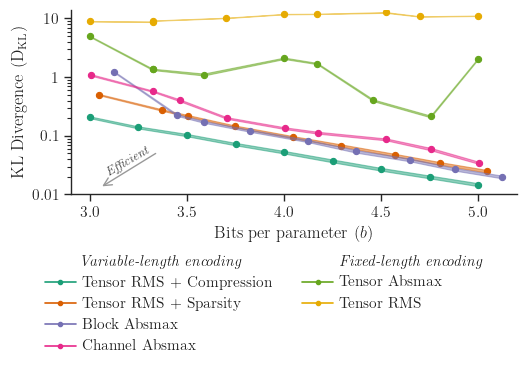

In [37]:
tradeoff_d = (D.select(dfb, dict(experiment="main"))
    .pipe(lambda d: d[~((d.scaling == "rms") & (d.block != "tensor") & (d.sparse_ratio != 0))])
    .pipe(lambda d: d.assign(block_absmax=((~d.block.isin(["tensor", "channel"])) & (d.scaling == "absmax"))))
)

_, ax = plt.subplots(figsize=(5.5, 2.75))

for select, args in SELECTED_FORMATS + BAD_FORMATS:
    g = D.select(tradeoff_d, dict(**select, model="Llama-3.1-8B"))
    y = "kl_div"
    ax.fill_between(g.bits_per_param, g[y] - 2*g[f"{y}_stderr"], g[y] + 2*g[f"{y}_stderr"], **args, alpha=.5)
    ax.scatter(g.bits_per_param, g[y], **args, s=20)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0f}" if x >= 1 else str(x))
ax.set_xlabel("Bits per parameter ($b$)", fontsize=12)
ax.set_ylabel(f"KL Divergence ({plot_utils.display_name("kl_div")})", fontsize=12)

ax.annotate(r"\textit{Efficient}", (3.31, 0.036), ha="right", va="center", fontsize=9, arrowprops=dict(arrowstyle="->", lw=2), color="#444", rotation=30)
ax.annotate(r"", (3.05, 0.013), xytext=(3.35, 0.053), textcoords="data", arrowprops=dict(arrowstyle="->", color="#999", lw=1))

plot_utils.set_figure_legend(ax.figure, build=[
    r"\textit{Variable-length encoding}",
    *(dict(**d, marker="o") for _, d in SELECTED_FORMATS + BAD_FORMATS[:1]),
    # "",
    r"\textit{Fixed-length encoding}",
    *(dict(**d, marker="o") for _, d in BAD_FORMATS[1:]),
    "", ""
],
    bbox_to_anchor=(0.0, 0.08, 1.0, 0), loc="upper center", ncols=2, columnspacing=2, handletextpad=0.4, fontsize=11)
ax.set_ylim((10**-2, 14))
ax.set_xlim((2.9, 5.2))
plot_utils.tidy(ax.figure)
plot_utils.save("workshop_tradeoff_overview_llama8b")

### `code:workshop_crd_block_t`

In [ ]:
def workshop_crd_block_t():
    from math import log, pi, sqrt  # IGNORE
    b, block_size, df = 4, 64, 7

    df_ = (df - 2) / 3
    scale = ((2 * log(block_size / pi)) ** ((3-df)/(2*df))
             * block_size ** (-1/df)
             * sqrt(3))

    c0, c1 = scipy.stats.t.cdf([-1, 1], df_, scale=scale)
    p = torch.linspace(c0, c1, 2**b)
    Q = torch.tensor(scipy.stats.t.ppf(p, df_, scale=scale))

    def quantise(x): return torch.bucketize(x, (Q[1:]+Q[:-1])/2)
    def dequantise(i): return Q[i]
    # IGNORE
    return Q, quantise, dequantise  # IGNORE

codepoints, quantise, dequantise = workshop_crd_block_t()
fmt = Q.crd_block_t(4, 64, 7)
X = torch.linspace(-1, 1, 101)

torch.testing.assert_close(codepoints, torch.tensor(fmt.values), atol=1e-6, rtol=0)
torch.testing.assert_close(dequantise(quantise(X)).float(), fmt.quantise(X))

plot_utils.save_code(workshop_crd_block_t)

### `workshop_eg_scaling_mode_3bit_normal`

remote: Updating references: 100% (1/1)           


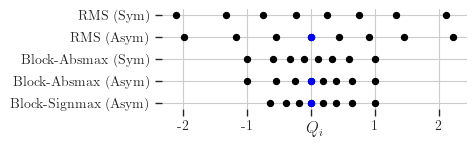

In [14]:
bits = 3
block_size = 64
dist = A.Normal()

_, ax = plt.subplots(figsize=(5, 1.7))

quantisers = [
    (dict(mode="symmetric"), dict(label="RMS (Sym)")),
    (dict(mode="asymmetric"), dict(label="RMS (Asym)")),
    (dict(scaling="absmax", block_size=block_size, mode="symmetric"), dict(label="Block-Absmax (Sym)")),
    (dict(scaling="absmax", block_size=block_size, mode="asymmetric"), dict(label="Block-Absmax (Asym)")),
    (dict(scaling="signmax", block_size=block_size, mode="asymmetric"), dict(label="Block-Signmax (Asym)")),
]
for y, (q, args) in enumerate(quantisers):
    ys = torch.full((2**bits,), -y)
    values = tensor(dist.quantiser(bits, **q).values)
    ax.scatter(values, ys, **args, color="k", s=20)
    zero = values.abs() < 1e-8
    ax.scatter(values[zero], ys[zero], color="b", s=20)


ax.grid(True)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
labels = ax.get_legend_handles_labels()[1]
ax.set_yticks(-torch.arange(len(labels)), labels, fontsize=10)
ax.set_ylim((-len(labels) + 1 - 0.25, 0.25))
ax.set_xlabel("$Q_i$", labelpad=-8, fontsize=12)
ax.set_xticks([-2, -1, 0, 1, 2], [-2, -1, "", 1, 2], fontsize=10)

plot_utils.tidy(ax.figure)
plot_utils.save("workshop_eg_scaling_mode_3bit_normal")

### `workshop_parameter_hist`

In [3]:
weight_stats = {run.config.model.split("/")[1]: run.summary.weight_stats for run in E.runs("20250423-weight-stats")}

bins = torch.arange(1, 20 + 1)
xs = torch.cat([bins, torch.tensor([21])]) - 0.5
n_samples = 2**28
studentt_df = 7

dist_data = {name: E.weight_stats.scaled_hist(t, bins, dim=None) for name, t in {
    "Normal": torch.randn(n_samples),
    "Laplace": torch.distributions.Laplace(0., 1.).sample((n_samples,)),
    f"t[$\\nu={studentt_df}$]": torch.distributions.StudentT(studentt_df).sample((n_samples,)),
}.items()}

remote: Updating references: 100% (1/1)           


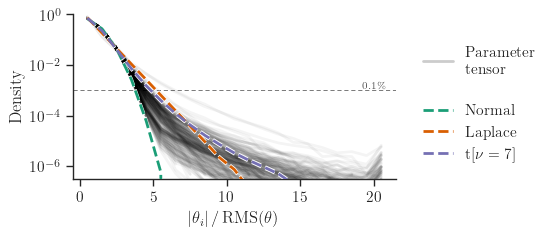

In [15]:
param_line = dict(color="k", lw=2, label="Parameter\ntensor")
dist_lines = [
    (name, dict(label=name, lw=2, ls="--", color=plot_utils.PALETTE[i]))
    for name, i in zip(dist_data, [0, 1, 2])
]

model = "Llama-3.1-8B"
_, ax = plt.subplots(figsize=(5.5, 2.6))

for p in weight_stats[model].values():
    if len(p["shape"]) == 2:
        hist = tensor(p["hist"])
        ax.plot(xs, torch.where(hist==0, torch.nan, hist), **param_line, alpha=10/len(weight_stats[model]), zorder=1)
for dist, args in dist_lines:
    ax.plot(xs, dist_data[dist]*1.1, zorder=100, **{**args, "color": "w"})  # hack an embossing effect to make the line easier to see
    ax.plot(xs, dist_data[dist]/1.1, zorder=100, **{**args, "color": "w"})
    ax.plot(xs, dist_data[dist], zorder=101, **args)
ax.axhline(10**-3, color="#444", lw=0.5, dashes=(6, 4), zorder=0)
ax.annotate(r"$0.1\%$", (20, 10**-3), ha="center", va="bottom", fontsize=7, color="#444")

ax.set_yscale("log")
ax.set_ylim((10**-6.5, 1))
ticks = [-6, -4, -2, 0]
ax.set_yticks([10**t for t in ticks], [f"$10^{{{t}}}$" for t in ticks])
ax.set_ylabel("Density", fontsize=12)
ax.set_xlabel(r"$|\theta_{i}| \,/\, \mathrm{RMS}(\theta)$", fontsize=12)

plot_utils.set_figure_legend(ax.figure, build=[dict(**param_line, alpha=.2), "", *dist_lines]),
plot_utils.tidy(ax.figure)
plot_utils.save("workshop_parameter_hist")

### `workshop_analysis_error_vs_bits`

remote: Updating references: 100% (1/1)           


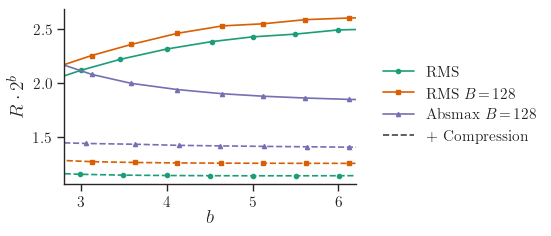

In [10]:
samples = 2**24
b_elems = torch.arange(2.5, 6.5 + 0.1, 0.5).tolist()
block_size = 128
scaling_block_size = [
    ("rms", None, dict(label="RMS", marker="o", color=plot_utils.PALETTE[0])),
    ("rms", block_size, dict(label=f"RMS $B\\!=\\!{block_size}$", marker="s", color=plot_utils.PALETTE[1])),
    ("absmax", block_size, dict(label=f"Absmax $B\\!=\\!{block_size}$", marker="^", color=plot_utils.PALETTE[2])),
]
dist = A.StudentT(df=5)
_, ax = plt.subplots(figsize=(5.5, 2.6))
X = dist.sample(samples, seed=1, device=DEVICE)
X_train = dist.sample(samples, seed=2, device=DEVICE)
for scaling, block_size, args in scaling_block_size:
    quantiser_block_size = None if scaling == "rms" else block_size

    bs, ys = [], []
    for b_elem in b_elems:
        fmt = Q.LinearScalingFormat(
            dist.quantiser(b_elem, scaling=scaling, block_size=quantiser_block_size),
            Q.BFLOAT16, (block_size,), scaling=scaling,
        )
        b = fmt.count_bits(X.shape) / X.nelement()
        ys.append(Q.qrmse_norm(fmt, X).item() * 2**b)
        bs.append(b)
    ax.plot(bs, ys, **plot_utils.drop_label(args))

    bs, ys = [], []
    for b_elem in b_elems:
        fmt = Q.LinearScalingFormat(
            dist.find_compressed_quantiser(
                b_elem,
                Q.block_normalise(X, (block_size,), scaling, (-1, 1), Q.FP32)[0],
                Q.block_normalise(X_train, (block_size,), scaling, (-1, 1), Q.FP32)[0],
                scaling=scaling,
                block_size=quantiser_block_size,
            ),
            Q.BFLOAT16, (block_size,), scaling=scaling,
        )
        b = fmt.count_bits_tensor(X) / X.nelement()
        ys.append(Q.qrmse_norm(fmt, X).item() * 2**b)
        bs.append(b)
    ax.plot(bs, ys, **plot_utils.drop_label(args), ls="--")

ax.set_xlim((3-0.2, 6+0.2))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.set_xlabel("bits", labelpad=0)
ax.set_ylabel(r"$R \cdot 2^b$")
ax.yaxis.set_major_formatter("{x}")
plot_utils.set_figure_legend(
    ax.figure,
    build=[*scaling_block_size, dict(color="#444", ls="--", label="+ Compression")],
    # bbox_to_anchor=(0.0, 0.08, 1.0, 0), loc="upper center", ncols=4, columnspacing=1.25, handletextpad=0.4,
)

plot_utils.tidy(ax.figure)
plot_utils.save("workshop_analysis_error_vs_bits")

### `workshop_xp_bit_allocation`

remote: Updating references: 100% (1/1)           


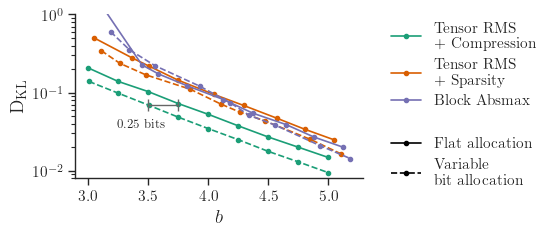

In [24]:
allocations = [
    ("fixed", dict(ls="-", marker="o", label="Flat allocation")),
    ("variable", dict(ls="--", marker="o", label="Variable\nbit allocation")),
]
_, ax0 = plt.subplots(figsize=(5.5, 2.6))

# Tradeoff plot
d = (D.select(dfb, dict(model="Llama-3.1-8B", experiment=["main", "fisher"], allocation=["fixed", "variable", "heuristic"], error_weight="none")))
for s, args in SELECTED_FORMATS:
    for a, aargs in allocations:
        g = D.select(d, dict(**s, allocation=a))
        ax0.plot(g.bits_per_param, g.kl_div, **args, **plot_utils.drop_label(aargs))
ax0.plot([3.5, 3.75], [0.07, 0.07], color="#666", marker="|", ms=9, linewidth=1, mew=1, zorder=100)
ax0.annotate("$0.25$ bits", (3.5, 0.07), (-5, -10), textcoords="offset points", ha="center", va="top", fontsize=9)

ax0.set_xlabel("bits_per_param")
ax0.set_ylabel("kl_div")
ax0.set_yscale("log")
ax0.set_ylim((8e-3, 1))

plot_utils.set_figure_legend(ax0.figure, build=[
    *((dict(**d, marker="o"),) for _, d in plot_utils.transform_labels(SELECTED_FORMATS, " + ", "\n+ ")),
    "", *allocations
])

plot_utils.tidy(ax0.figure)
plot_utils.save("workshop_xp_bit_allocation")